In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
sns.set_theme(style="white")

UNKNOWN = 'unknown'
RANDOM_STATE = 2021

## Import protest data

In [2]:
engine_protests = create_engine('sqlite:///../data/processed/mobilizations.db')
                                #'sqlite:///../data/processed/mobilizations.db'

with engine_protests.begin() as connection:
    protests = pd.read_sql('SELECT * FROM mass_mobilizations', connection)
    
protests['start_datetime'] = pd.to_datetime(protests.start_datetime)
protests['end_datetime'] = pd.to_datetime(protests.end_datetime)
protests['duration'] = protests.end_datetime - protests.start_datetime

In [3]:
protests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15208 entries, 0 to 15207
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype          
---  ------                              --------------  -----          
 0   index                               15208 non-null  int64          
 1   id                                  15208 non-null  int64          
 2   country                             15208 non-null  object         
 3   ccode                               15208 non-null  int64          
 4   location                            15208 non-null  object         
 5   region                              15208 non-null  object         
 6   protestnumber                       15208 non-null  int64          
 7   protesterviolence                   15208 non-null  int64          
 8   protesteridentity                   15208 non-null  object         
 9   startyear                           15208 non-null  int64          
 10  startmonth

# Modeling

In [49]:
def train_test(x, y):
    return train_test_split(x, y, random_state=RANDOM_STATE)

##### Remove items that won't be used in FSM

In [4]:
protests.columns

Index(['index', 'id', 'country', 'ccode', 'location', 'region',
       'protestnumber', 'protesterviolence', 'protesteridentity', 'startyear',
       'startmonth', 'startday', 'endyear', 'endmonth', 'endday',
       'start_datetime', 'end_datetime', 'duration', 'participants',
       'participants_category_original', 'participants_category_manufactured',
       'sources', 'notes', 'demand_labor-wage-dispute',
       'demand_land-farm-issue', 'demand_police-brutality',
       'demand_political-behavior/process',
       'demand_price-increases/tax-policy', 'demand_removal-of-politician',
       'demand_social-restrictions', 'response_accomodation',
       'response_arrests', 'response_beatings', 'response_crowd-dispersal',
       'response_ignore', 'response_killings', 'response_shootings'],
      dtype='object')

In [33]:
demand_cols = ['demand_labor-wage-dispute', 'demand_land-farm-issue', 'demand_police-brutality',
               'demand_political-behavior/process', 'demand_price-increases/tax-policy', 
               'demand_removal-of-politician', 'demand_social-restrictions']

response_cols = ['response_accomodation', 'response_arrests', 'response_beatings', 
                 'response_crowd-dispersal', 'response_ignore', 'response_killings', 'response_shootings']

input_cols = ['ccode', 'protestnumber', 'protesterviolence', 'start_datetime', 'end_datetime', 'duration', 'participants']

df_model = protests[cols_to_include + demand_cols]

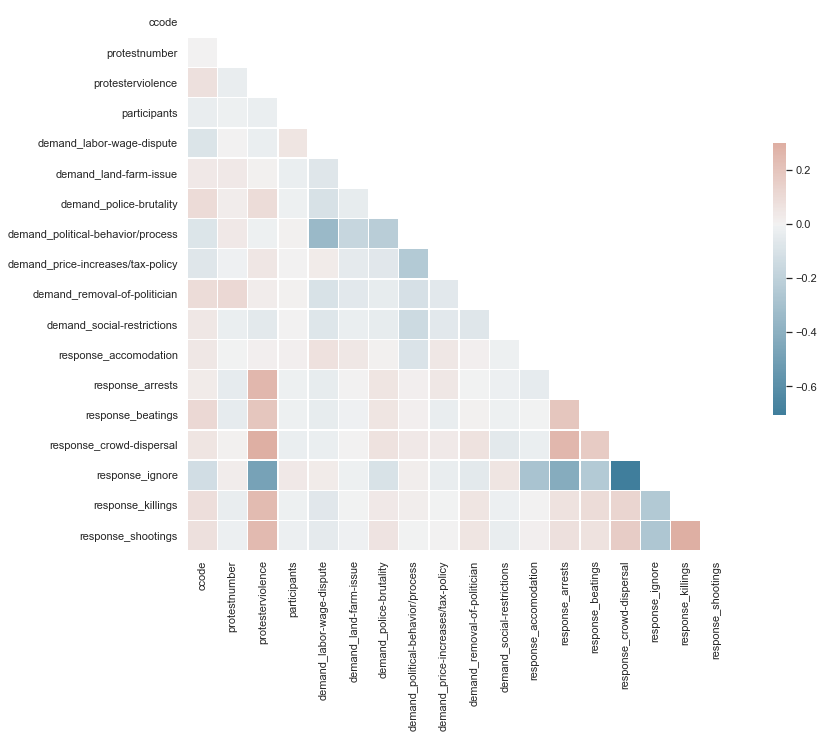

In [34]:
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### Test linear regression on Response: Accomodation

In [35]:
df_model = protests[cols_to_include + demand_cols]

In [36]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15208 entries, 0 to 15207
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   ccode                              15208 non-null  int64          
 1   protestnumber                      15208 non-null  int64          
 2   protesterviolence                  15208 non-null  int64          
 3   start_datetime                     15208 non-null  datetime64[ns] 
 4   end_datetime                       15208 non-null  datetime64[ns] 
 5   duration                           15208 non-null  timedelta64[ns]
 6   participants                       15208 non-null  int64          
 7   demand_labor-wage-dispute          15208 non-null  int64          
 8   demand_land-farm-issue             15208 non-null  int64          
 9   demand_police-brutality            15208 non-null  int64          
 10  demand_political-behav

In [50]:
x = df_model.drop(['start_datetime', 'end_datetime', 'duration'], axis=1)
y = protests['response_accomodation']

x_train, x_test, y_train, y_test = train_test(x, y)

In [60]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(x_train, y_train)

linreg.predict(x_test)


array([-1.01443029e-15, -1.52018905e-15, -1.95519430e-15, ...,
       -1.52396837e-15, -9.96529438e-16, -5.94996265e-16])